In [1]:
from abc import ABC, abstractmethod
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

sns.set_style("white")

In [2]:
class Data(ABC):
    @abstractmethod
    def sample(self):
        pass

    @abstractmethod
    def k_z_next(self, z_next):
        pass

    @abstractmethod
    def update_model(self, z_next):
        pass

    @abstractmethod
    def reset(self):
        pass


class RandomData(Data):
    def __init__(self, z_dim):
        self.z_dim = z_dim

    def sample(self):
        return "".join([str(int(random() > 0.5)) for _ in range(self.z_dim)])

    def k_z_next(self, z_next):
        return self.z_dim

    def update_model(self, z_next):
        return

    def reset(self):
        return


class CompositionalData(Data):
    def __init__(self, z_dim, sentence_length, vocab_size, noise_dims=0):
        self.z_dim = z_dim
        self.noise_dims = noise_dims
        self.sentence_length = sentence_length
        self.vocab_size = vocab_size
        self.word_dim = (z_dim - noise_dims) // sentence_length
        assert vocab_size <= 2**self.word_dim

        self.true_model = [
            [format(i, f"0{self.word_dim}b") for i in range(vocab_size)]
            for _ in range(sentence_length)
        ]
        self.model = None
        self.reset()

    def chunk_z(self, z):
        return [
            z[i : i + self.word_dim]
            for i in range(0, self.z_dim - self.noise_dims, self.word_dim)
        ]

    def sample(self):
        sentence = [
            int(random() * self.vocab_size) for _ in range(self.sentence_length)
        ]
        z = "".join([self.true_model[i][word] for i, word in enumerate(sentence)])
        z += "".join([str(int(random() > 0.5)) for _ in range(self.noise_dims)])
        return z

    def k_z_next(self, z_next):
        z_next = z_next[: -self.noise_dims] if self.noise_dims > 0 else z_next
        z_next = self.chunk_z(z_next)
        k = 0.0
        for i, z_chunk in enumerate(z_next):
            if z_chunk not in self.model[i]:
                k += self.word_dim
            else:
                k += np.log2(len(self.model[i]))
        k += self.noise_dims
        return k

    def update_model(self, z_next):
        z_next = z_next[: -self.noise_dims] if self.noise_dims > 0 else z_next
        z_next = self.chunk_z(z_next)
        for i, z_chunk in enumerate(z_next):
            if z_chunk not in self.model[i]:
                self.model[i].append(z_chunk)

    def reset(self):
        self.model = [[] for _ in range(self.sentence_length)]


class FactData(CompositionalData):
    def __init__(self, z_dim, num_facts, noise_dims=0):
        super().__init__(
            z_dim=z_dim, sentence_length=1, vocab_size=num_facts, noise_dims=noise_dims
        )


class ConstantData(FactData):
    def __init__(self, z_dim, noise_dims):
        super().__init__(z_dim=z_dim, num_facts=1, noise_dims=noise_dims)


def preq_curve(data: Data, num_samples: int, num_repeats: int):
    curve = []
    for j in tqdm(range(num_repeats)):
        data.reset()
        for i in range(num_samples):
            z_next = data.sample()
            k_z_next = data.k_z_next(z_next)
            data.update_model(z_next)
            curve.append({"i": i + 1, "k_z_next": k_z_next, "repeat": j})
    return pd.DataFrame(curve)


def preq_curve_comparison(datas: dict[str, Data], num_samples: int, num_repeats: int):
    curves = None
    for name, data in datas.items():
        curves_i = preq_curve(data, num_samples, num_repeats)
        curves_i["name"] = name
        if curves is None:
            curves = curves_i
        else:
            curves = pd.concat([curves, curves_i])
    return curves

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1435.27it/s]


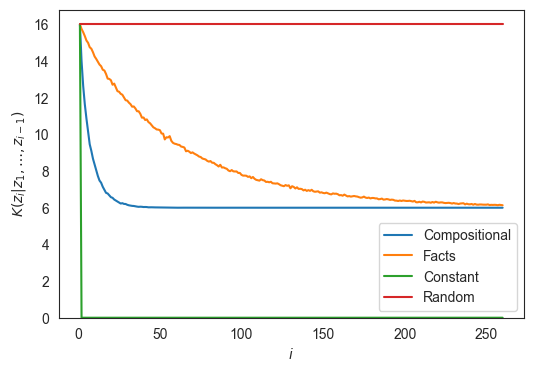

In [5]:
z_dim = 16
num_facts = 64
sentence_length = 2
vocab_size = 8
const_noise_dims = 6
assert num_facts == vocab_size**sentence_length == 2**const_noise_dims

preq_curves = preq_curve_comparison(
    datas={
        "Random": RandomData(z_dim=z_dim),
        "Constant": ConstantData(z_dim=z_dim, noise_dims=0),
        "Constant + noise": ConstantData(z_dim=z_dim, noise_dims=const_noise_dims),
        "Facts": FactData(z_dim=z_dim, num_facts=num_facts),
        "Compositional": CompositionalData(
            z_dim=z_dim, sentence_length=sentence_length, vocab_size=vocab_size
        ),
    },
    num_samples=260,
    num_repeats=10000,
)
preq_curves = preq_curves.groupby(["name", "i"])["k_z_next"].mean().reset_index()

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=preq_curves,
    x="i",
    y="k_z_next",
    hue="name",
    hue_order=["Compositional", "Facts", "Constant", "Random"],
    ax=ax,
)
ax.set(xlabel="$i$", ylabel="$K(z_i | z_1, \ldots, z_{i-1})$", ylim=(0, None))
ax.legend()
plt.show()

# Multi-scale structure

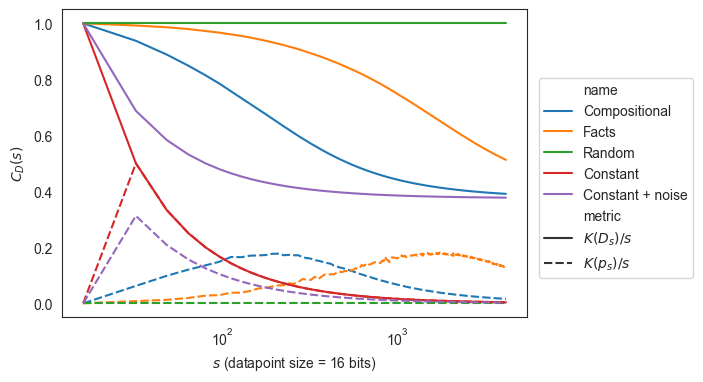

In [6]:
def k(preq_curve):
    return preq_curve.cumsum()


def k_uncompressed(preq_curve):
    k1 = preq_curve.iloc[0].item()
    preq_curve = preq_curve.copy()
    preq_curve[:] = k1
    return preq_curve.cumsum()


def k_entropy(preq_curve):
    return preq_curve * np.arange(1, len(preq_curve) + 1)


def k_shared(preq_curve):
    return k_uncompressed(preq_curve) - k(preq_curve)


def k_f(preq_curve):
    return k(preq_curve) - k_entropy(preq_curve)


preq_curves = preq_curves.sort_values(["name", "i"])
preq_curves["s"] = preq_curves["i"] * z_dim
grouped = preq_curves.groupby("name")["k_z_next"]
preq_curves = preq_curves.assign(
    k=grouped.transform(k),
    k_shared=grouped.transform(k_shared),
    k_f=grouped.transform(k_f),
)
preq_curves["kf/k"] = preq_curves["k_f"] / preq_curves["k"]
preq_curves["$K(D_s) / s$"] = preq_curves["k"] / preq_curves["s"]
preq_curves["$K(p_s) / s$"] = preq_curves["k_f"] / preq_curves["s"]

pivoted = preq_curves.melt(
    id_vars=["name", "i", "s"],
    value_vars=["k", "k_shared", "k_f", "kf/k", "$K(D_s) / s$", "$K(p_s) / s$"],
    var_name="metric",
    value_name="k_metric",
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=pivoted[pivoted["metric"].isin(["$K(D_s) / s$", "$K(p_s) / s$"])],
    x="s",
    y="k_metric",
    hue="name",
    hue_order=["Compositional", "Facts", "Random", "Constant", "Constant + noise"],
    style="metric",
    style_order=["$K(D_s) / s$", "$K(p_s) / s$"],
    ax=ax,
)
ax.set(xlabel=f"$s$ (datapoint size = {z_dim} bits)", ylabel="$C_D(s)$", xscale="log")
ax.legend(bbox_to_anchor=(1.01, 0.8))
plt.show()